In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display
from scipy.spatial import cKDTree

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.dynamics import mockstream as ms

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import InterpolatedUnivariateSpline
import h5py

import sys
if '../scripts' not in sys.path:
    sys.path.append('../scripts')
from streamsubhalosim import get_in_stream_frame, get_stream_track

In [14]:
pot = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s,
                                             r_s=15*u.kpc,
                                             units=galactic)
prog_w0 = gd.PhaseSpacePosition(pos=[10, 0, 0.] * u.kpc,
                                vel=[0, 170, 0.] * u.km/u.s)

In [76]:
# df = ms.LagrangeCloudStreamDF(v_disp=1*u.km/u.s)
df = ms.FardalStreamDF()
gen = ms.MockStreamGenerator(df, gp.Hamiltonian(pot))

In [77]:
stream, prog = gen.run(
    prog_w0, 1e5*u.Msun,
    dt=-0.5 * u.Myr, n_steps=6000, n_particles=4
)

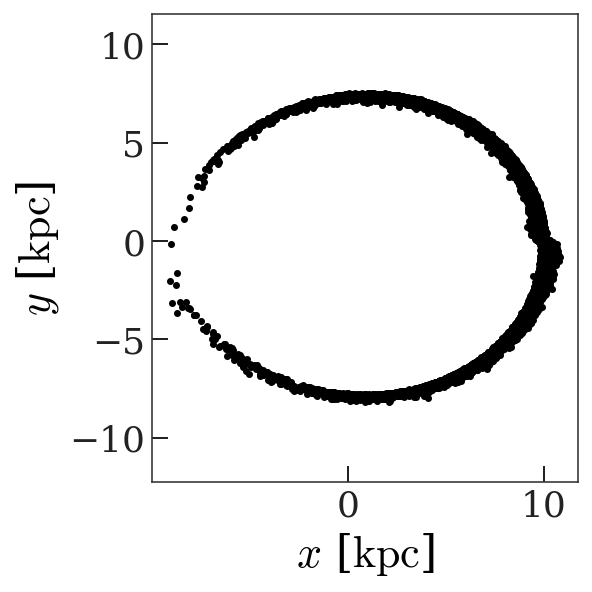

In [78]:
stream.plot(['x', 'y']);

In [79]:
stream_gal = stream.to_coord_frame(coord.Galactic())

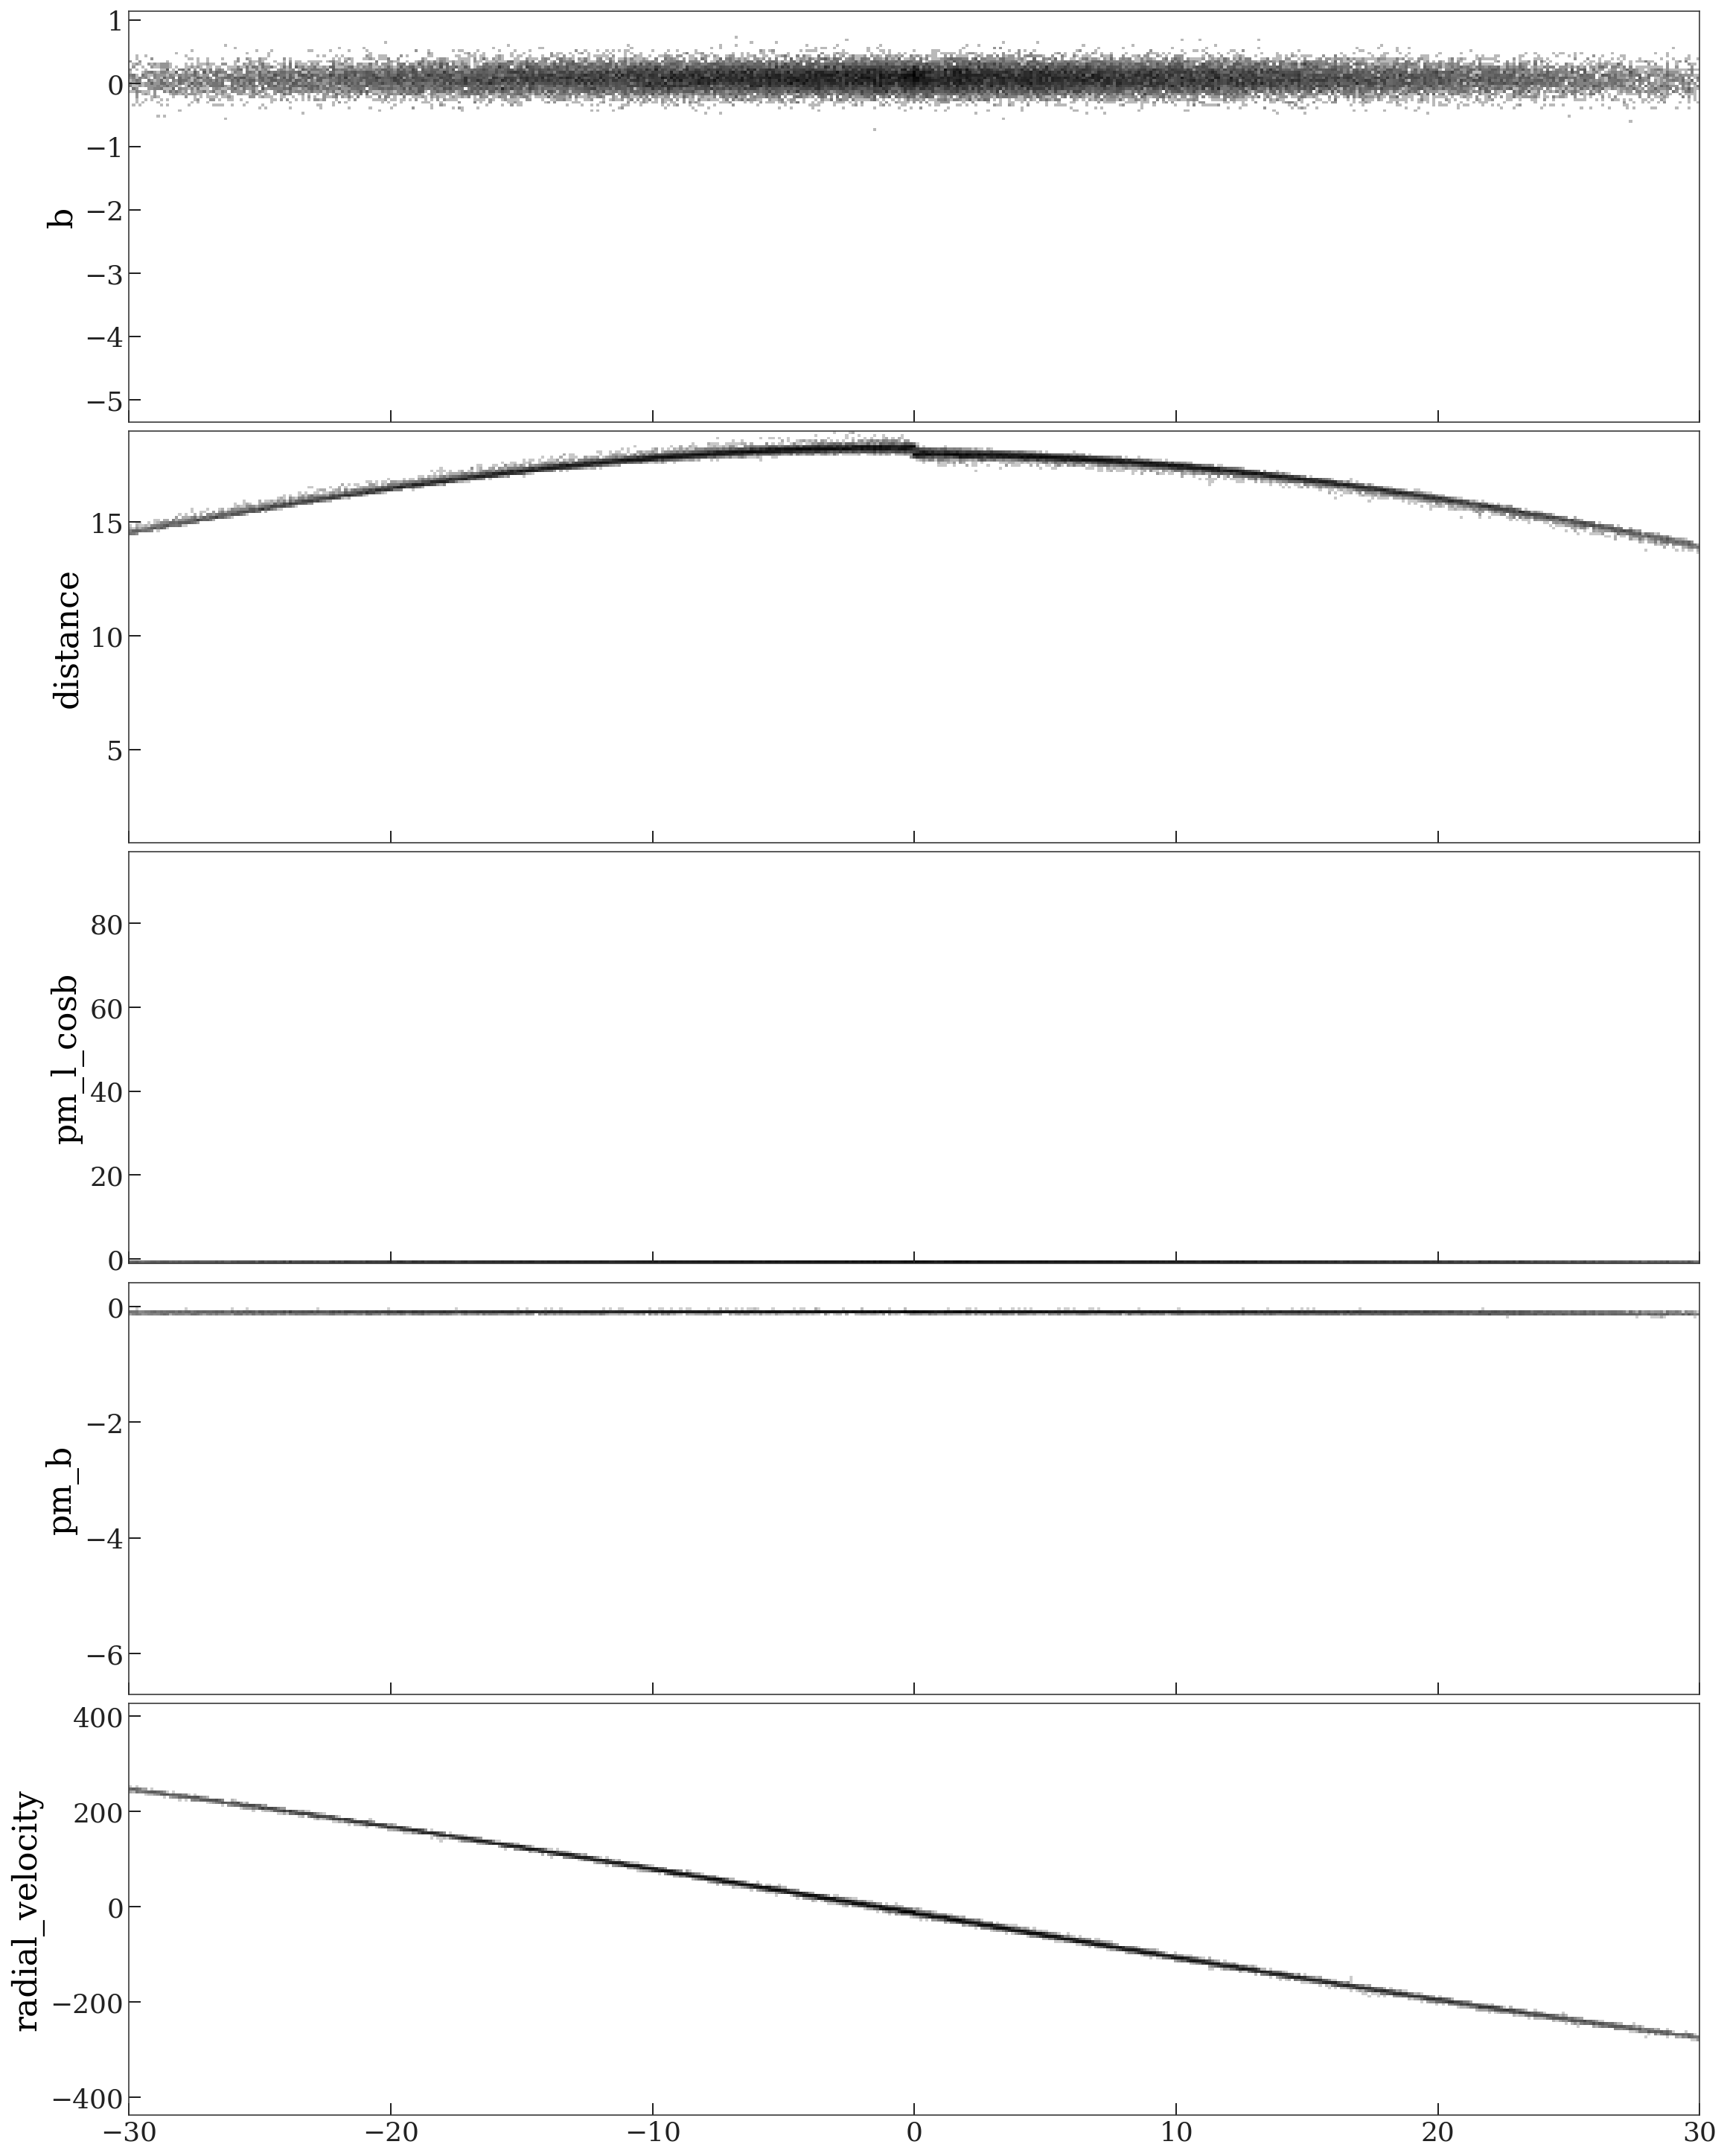

In [80]:
fig, axes = plt.subplots(
    5, 1, figsize=(16, 20), sharex=True, constrained_layout=True
)

lon = stream_gal.l.wrap_at(180*u.deg).degree
comps = ["b", "distance", "pm_l_cosb", "pm_b", "radial_velocity"]
for ax, comp in zip(axes, comps):
    ax.hist2d(
        lon,
        getattr(stream_gal, comp).value,
        bins=(np.linspace(-30, 30, 512), 151),
        norm=mpl.colors.LogNorm(vmin=0.1),
        cmap="Greys",
    )
    ax.set_ylabel(comp)

In [2]:
with h5py.File("../cache/stream-sims.hdf5", "r") as f:
    stream = gd.PhaseSpacePosition.from_hdf5(f['init/stream'])
    impact_site = gd.PhaseSpacePosition.from_hdf5(f['init/impact_site'])

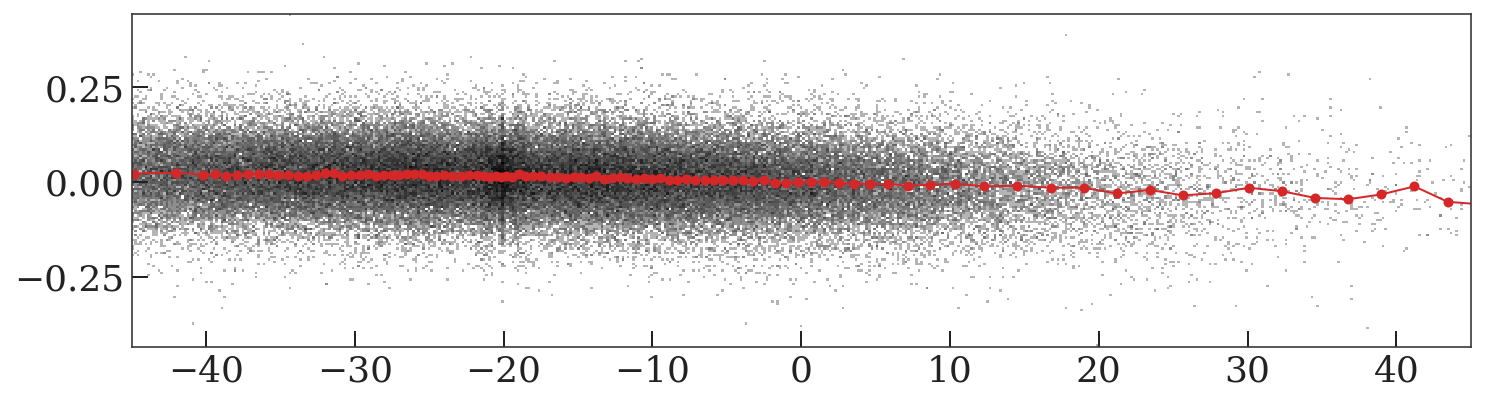

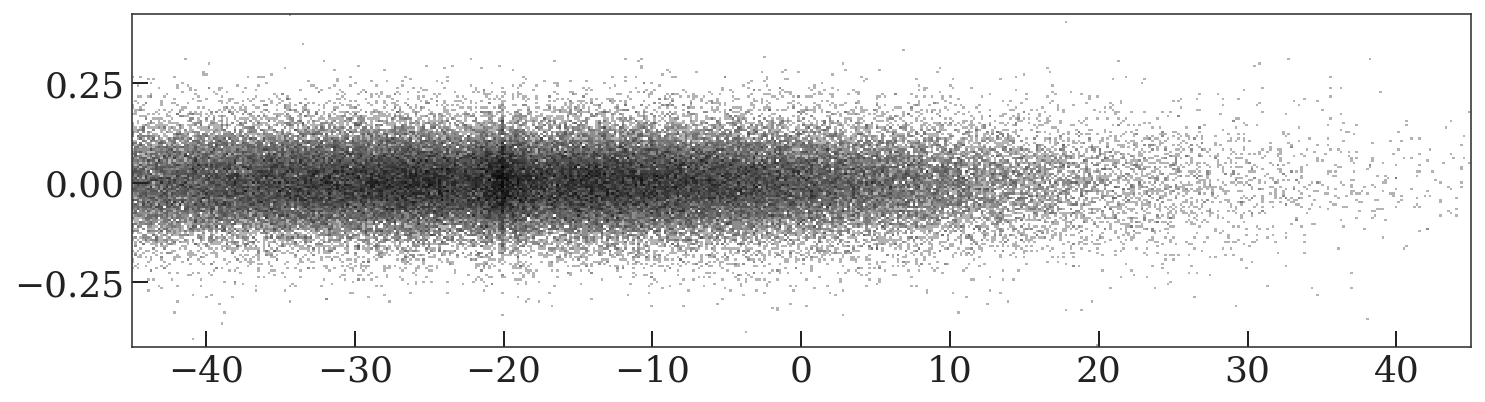

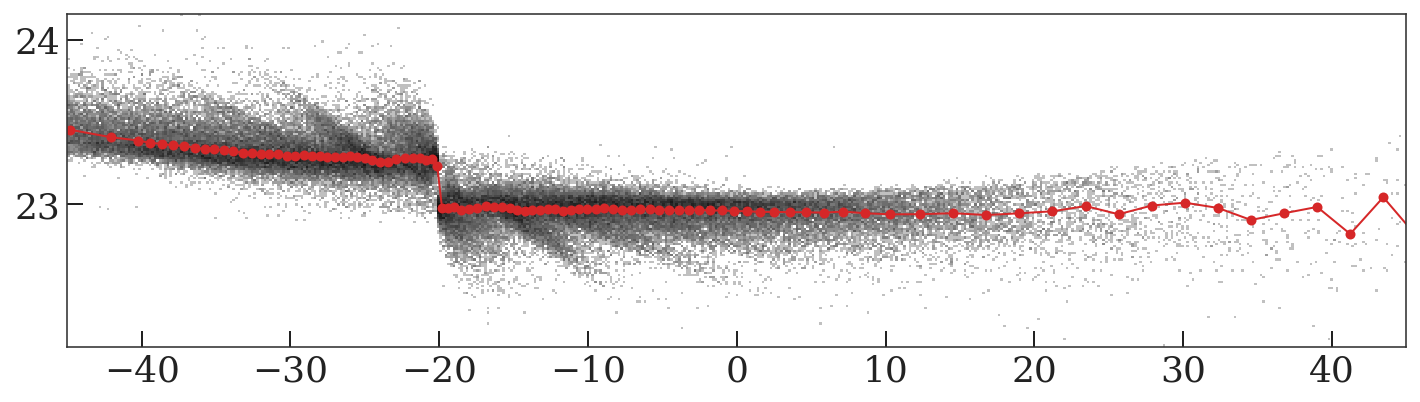

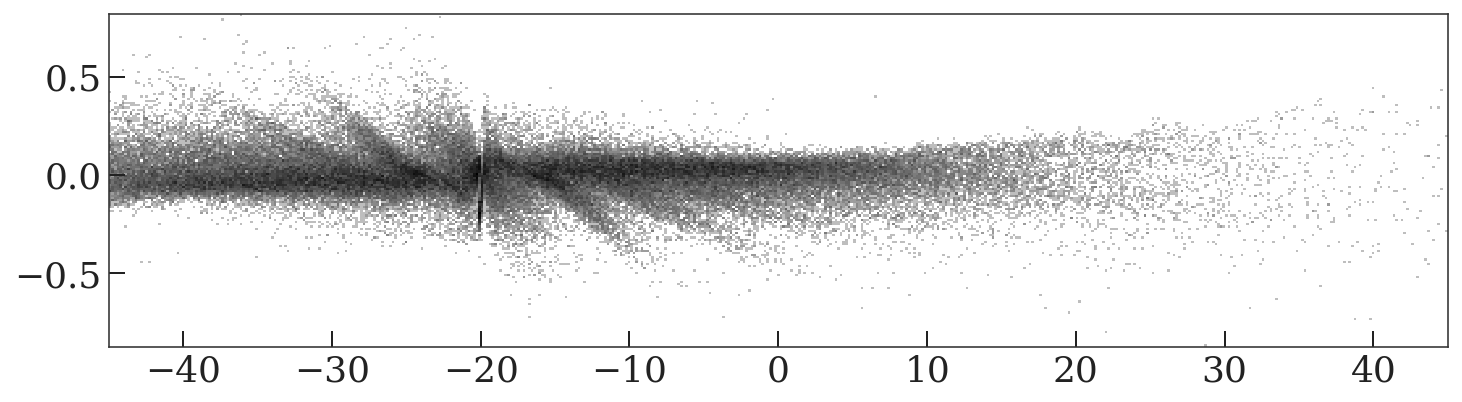

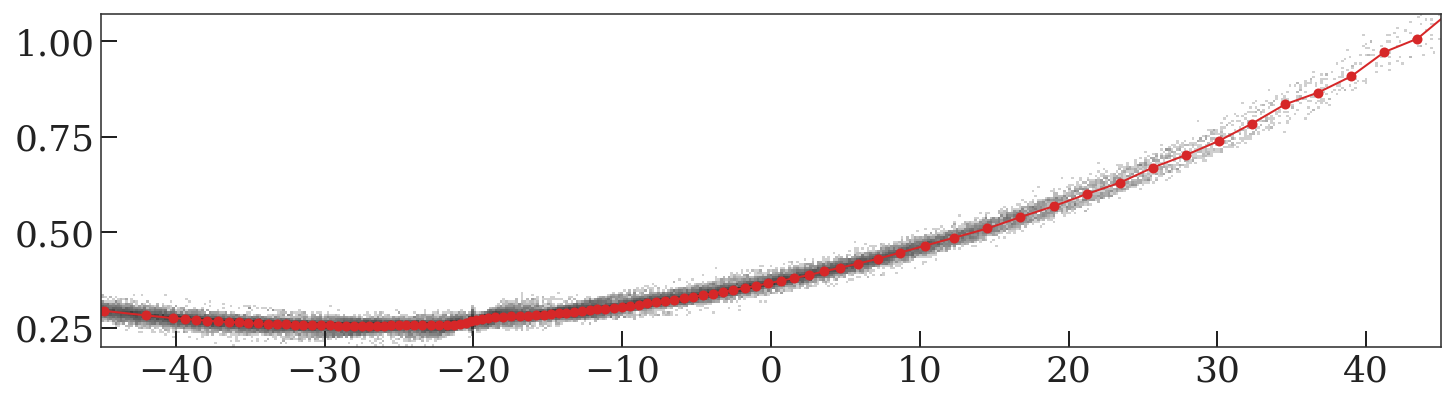

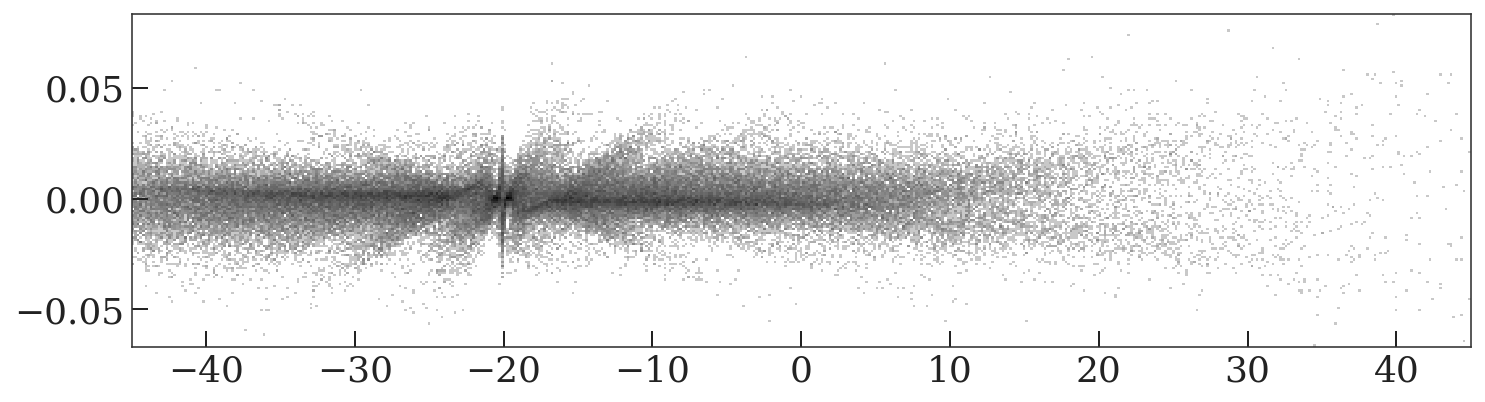

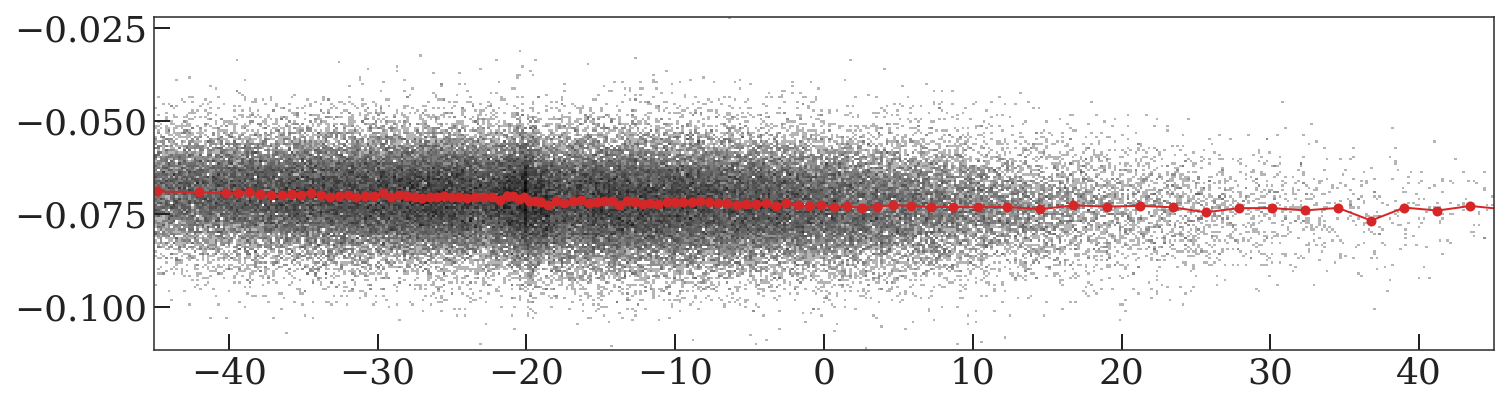

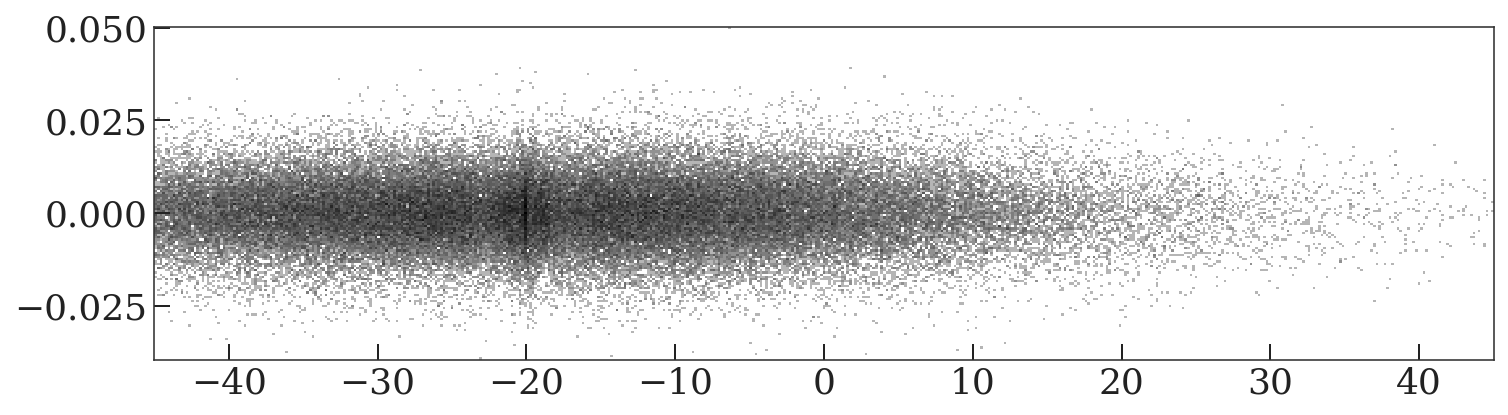

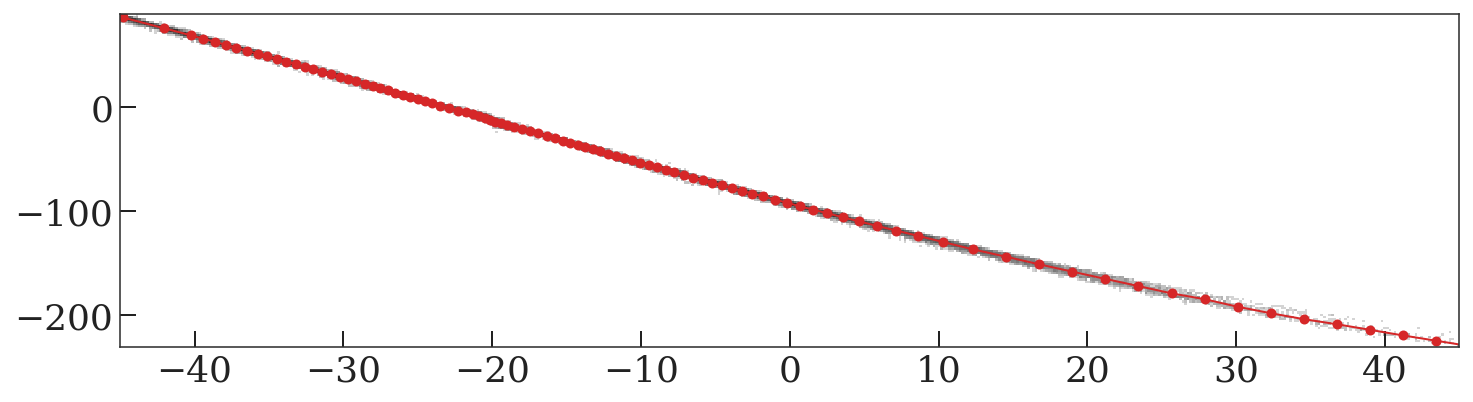

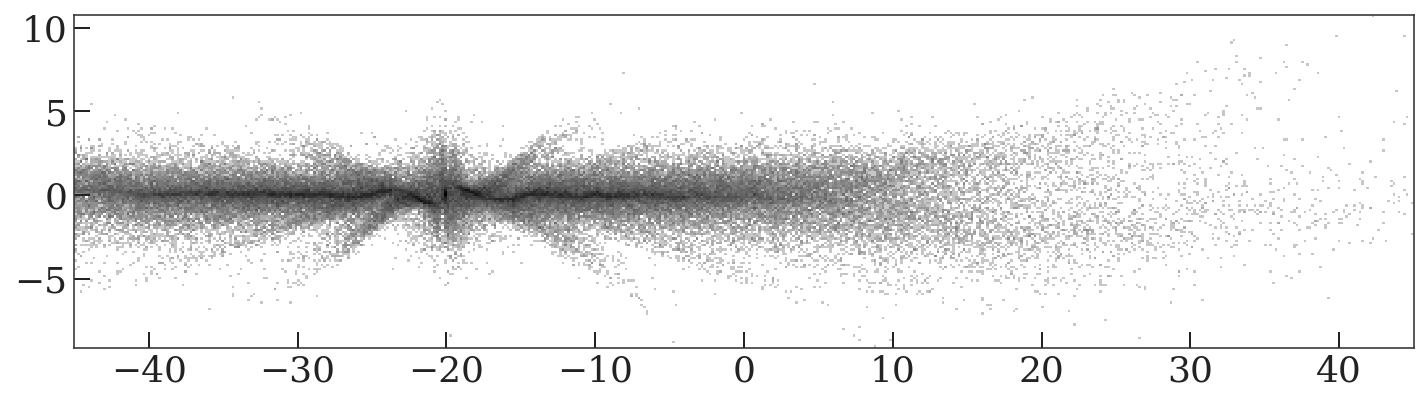

In [3]:
stream_sfr = get_in_stream_frame(stream, impact_site)
tracks = get_stream_track(stream_sfr, lon_lim=(-45, 45), plot_debug=True)

<SkyOffsetGalactic Frame (rotation=0.0 deg, origin=<Galactic Coordinate: (l, b, distance) in (deg, deg, kpc)
    (19.91304461, 0.08547921, 22.92907405)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.36777869, -0.07268668, -92.58179592)>)>

---

In [1]:
# Third-party
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic, UnitSystem

from gala.dynamics.nbody import DirectNBody

In [2]:
nblob = 4096

blob_xyz = np.zeros((3, nblob)) * u.pc
blob_xyz[0] = np.linspace(-100, 100, nblob) * u.pc

blob_vxyz = np.zeros((3, nblob)) * u.km/u.s
blob_vy = 1. * u.km/u.s
blob_vxyz[0] = blob_vy

blob_w0 = gd.PhaseSpacePosition(pos=blob_xyz, vel=blob_vxyz)

In [3]:
perturber_w0 = gd.PhaseSpacePosition(pos=[0, 0, 0] * u.pc,
                                     vel=[0, 5, 0] * u.pc/u.Myr)

In [4]:
# w0 = gd.combine((perturber_w0, blob_w0)) # at time of impact
w0 = gd.combine((blob_w0, perturber_w0)) # at time of impact

In [5]:
ext_pot = gp.NullPotential(units=galactic)
w0_back = ext_pot.integrate_orbit(w0, dt=-0.1*u.Myr, t1=0, t2=-20*u.Myr)[-1]

In [6]:
# pps = [gp.HernquistPotential(m=1e2*u.Msun, c=0.1*u.pc, units=galactic)] + [None] * nblob
pps = [None] * nblob + [gp.HernquistPotential(m=1e2*u.Msun, c=0.1*u.pc, units=galactic)]

In [7]:
nbody = DirectNBody(w0_back, pps, save_all=False)
orbits = nbody.integrate_orbit(dt=0.1*u.Myr, t1=-20*u.Myr, t2=100*u.Myr)

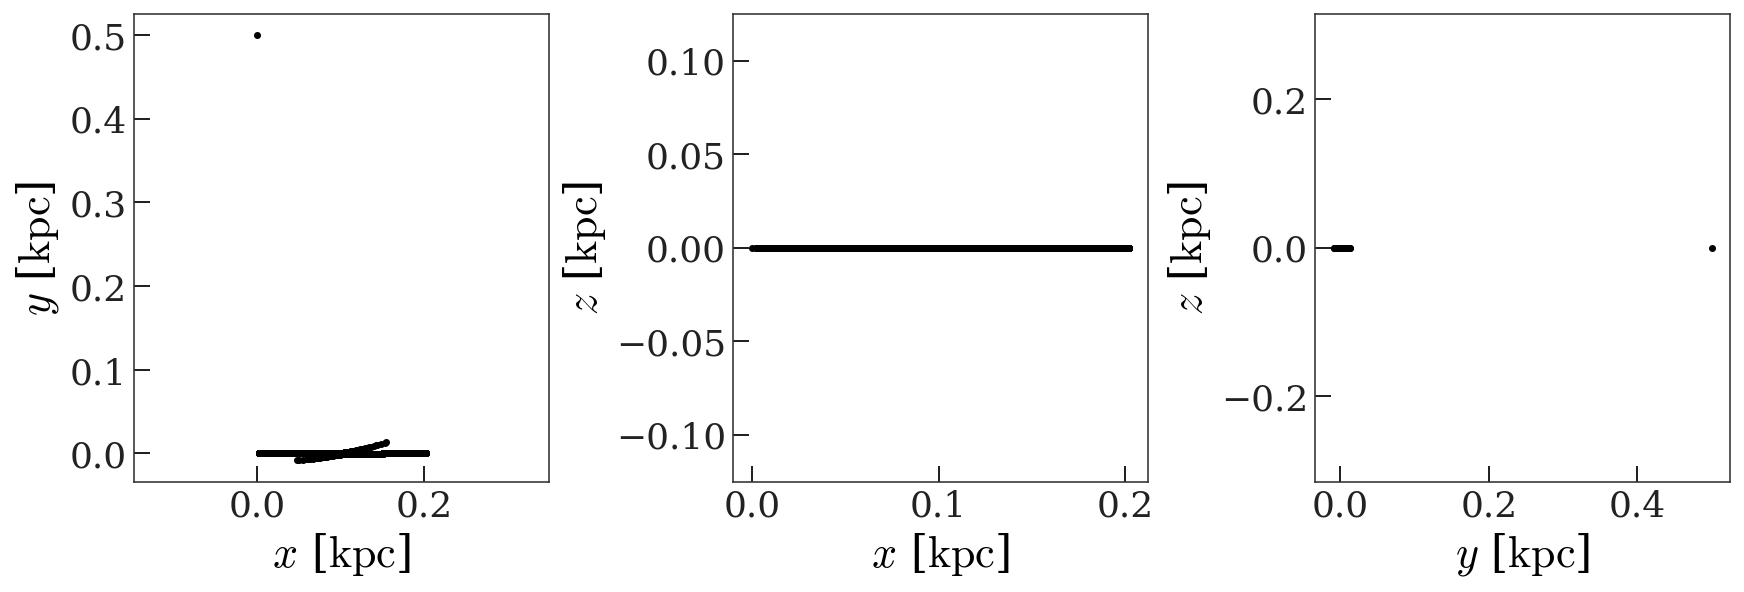

In [9]:
orbits.plot();